# 世界中の災害被害の死者数について

    今回は、1900年からの世界順の災害データを用いてどの災害がどこの地域で多くどのくらい深刻なのかを調べていきました。

　


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
emdat = pd.read_csv('emdat.csv')

In [2]:
emdat.head()  # Display the first few rows

,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0


まず最初に、ヒートマップを作って簡単にどこの国でどの被害が多いいのかを可視化してみました。

In [3]:
pip install json

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\gatai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install japanize_matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\gatai\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


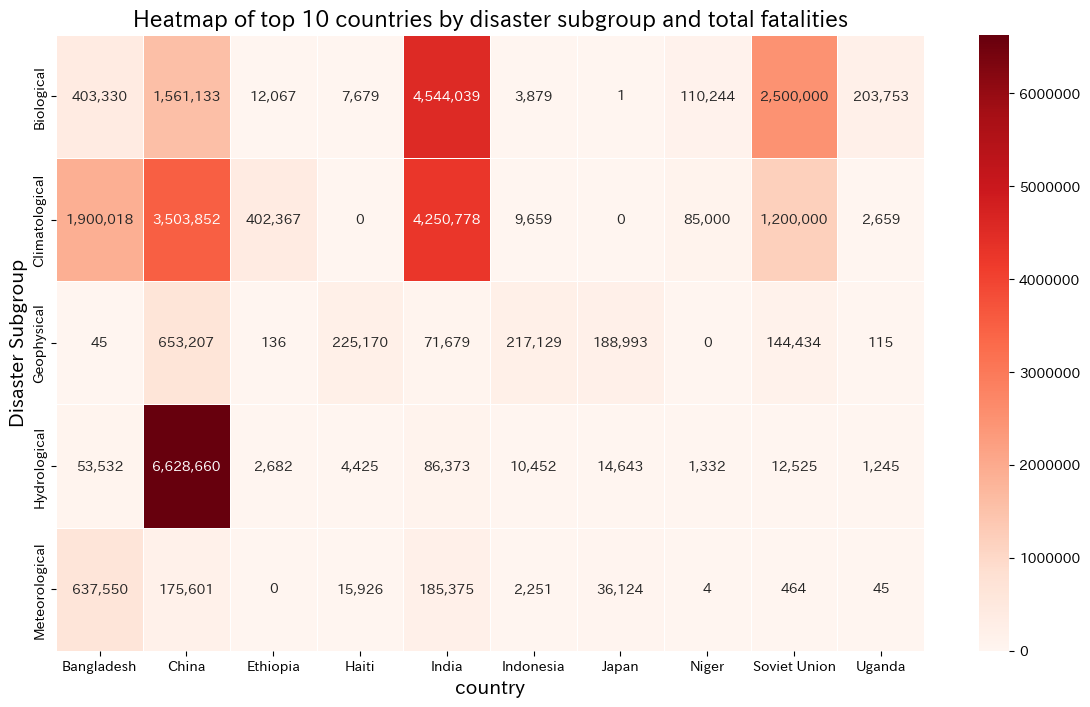

In [5]:
import japanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# データの読み込み
df = pd.read_csv('emdat.csv')

# --- データの前処理 ---

# 1. 必要な列を抽出・クリーンアップ
# Total DeathsとDisaster Subgroup、Countryを対象
cols = ['Disaster Subgroup', 'Country', 'Total Deaths']
df_clean = df[cols].dropna()

# Total Deathsを数値型に変換し、NaNを削除
df_clean['Total Deaths'] = pd.to_numeric(df_clean['Total Deaths'], errors='coerce')
df_clean = df_clean.dropna(subset=['Total Deaths'])

# 2. 総死者数の多い上位10カ国を特定
top_10_countries = df_clean.groupby('Country')['Total Deaths'].sum().nlargest(10).index.tolist()

# 3. データを上位10カ国に絞り込む
df_top_countries = df_clean[df_clean['Country'].isin(top_10_countries)]

# 4. 'Disaster Subgroup'と'Country'でグループ化し、総死者数を合計
heatmap_data = df_top_countries.groupby(['Disaster Subgroup', 'Country'])['Total Deaths'].sum().unstack(fill_value=0)

# --- 2. ヒートマップの作成 ---

# グラフのサイズを設定
plt.figure(figsize=(14, 8))

# ヒートマップの描画
# cbar_kwsでカラーバーの表示形式をカンマ区切りに設定
ax = sns.heatmap(
    heatmap_data,
    annot=True,              # セルに数値を表示
    fmt=",.0f",              # 数値をカンマ区切りで表示 (例: 1,234,567)
    cmap="Reds",             # 色のスケール (死者数が多いほど赤が濃くなる)
    linewidths=.5,           # セルの枠線
    linecolor='white',
    cbar_kws={'format': '%.0f'}
)

# グラフのタイトルとラベル
plt.title('Heatmap of top 10 countries by disaster subgroup and total fatalities', fontsize=16)
plt.xlabel('country', fontsize=14)
plt.ylabel('Disaster Subgroup', fontsize=14)

plt.show()
#

これより、中国でのHydrological（洪水など）災害の死者数が非常に多いことがわかります。また、インドでは、Biological(細菌など)やClimatlogical(天候など)の被害が多く存在していることがわかりました。

ここで、ほかの地域と比べて被害の数がどのくらいの差があるのかを地図上にしていきたいと思います。

In [6]:
import pandas as pd
import folium
import requests
import json

# 💡 必要なライブラリがない場合:
# pip install folium pandas requests

# ISOコードと国境線情報を持つGeoJSONファイル (世界中の国境データ) のURL
# Foliumの公式ドキュメントでよく使われる公開データです。
GEOJSON_URL = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

# データの読み込み
df = pd.read_csv('emdat.csv')

# --- 1. 洪水データの集計 ---
# Disaster Typeが 'Flood' の行のみを抽出
flood_df = df[df['Disaster Type'] == 'Flood']

# ISOコードを抽出・クリーンアップ
flood_df_clean = flood_df[['ISO']].dropna(subset=['ISO'])

# ISOコードごとに災害の発生回数をカウント
country_flood_counts = flood_df_clean.groupby('ISO').size().reset_index(name='Flood_Count')

# --- 2. GeoJSONデータの取得 ---
print("GeoJSONデータをダウンロード中...")
try:
    response = requests.get(GEOJSON_URL)
    geojson_data = response.json()
    print("GeoJSONデータのダウンロードが完了しました。")
except requests.exceptions.RequestException as e:
    print(f"GeoJSONの取得中にエラーが発生しました。ネットワーク接続やURLを確認してください: {e}")
    geojson_data = None


# --- 3. Folium地図の作成 ---

if geojson_data:
    # 世界地図の中心座標を指定して初期化
    m = folium.Map(location=[30, 0], zoom_start=2)
    
    # データを結合してChoroplethレイヤーを追加
    folium.Choropleth(
        geo_data=geojson_data,
        name='洪水発生回数',
        data=country_flood_counts,
        columns=['ISO', 'Flood_Count'],
        key_on='feature.id',        # GeoJSON内の国コード（ISO）を参照するキー
        fill_color='YlOrRd',        # 色のスケール (黄色から赤へ: 発生回数が多いほど赤が濃くなります)
        fill_opacity=0.7,           # 塗りつぶしの不透明度
        line_opacity=0.2,           # 国境線の不透明度
        legend_name='洪水発生回数 (全期間)',
        highlight=True              # ホバー時にハイライト表示を有効化
    ).add_to(m)

    # 地図をHTMLファイルとして保存
    # このファイルをブラウザで開くと、インタラクティブな地図が表示されます。
    map_file_name = "flood_frequency_map_folium.html"
    m.save(map_file_name)
    print(f"地図を '{map_file_name}' として保存しました。")
  
    # Jupyter Notebookなどの環境では、地図を直接表示することもできます。
    # m

GeoJSONデータをダウンロード中...
GeoJSONデータのダウンロードが完了しました。
地図を 'flood_frequency_map_folium.html' として保存しました。


![洪水被害の世界地図](世界の洪水.png)

黒くなっている地域はおそらくデータのない地域であると予想しています。
このようにしてみると洪水被害は圧倒的に東南アジアで多く発生していることがわかります。次にBiologicalの被害を地図上に起こしてみます。

In [7]:
import pandas as pd
import folium
import requests
import json

# ISOコードと国境線情報を持つGeoJSONファイル (世界中の国境データ) のURL
GEOJSON_URL = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

# データの読み込み
df = pd.read_csv('emdat.csv')

# --- 1. 生物学的災害データの集計 ---
# Disaster Subgroupが 'Biological' の行のみを抽出
biological_df = df[df['Disaster Subgroup'] == 'Biological'].copy()

# ISOコードを抽出・クリーンアップ
biological_df_clean = biological_df[['ISO']].dropna(subset=['ISO'])

# ISOコードごとに災害の発生回数をカウント
country_bio_counts = biological_df_clean.groupby('ISO').size().reset_index(name='Biological_Count')

# 死者数データを辞書形式に変換 (ISOコード -> 発生回数)
bio_count_dict = country_bio_counts.set_index('ISO')['Biological_Count'].to_dict()

# --- 2. GeoJSONデータの取得 ---
print("GeoJSONデータをダウンロード中...")
try:
    response = requests.get(GEOJSON_URL)
    geojson_data = response.json()
    print("GeoJSONデータのダウンロードが完了しました。")
except requests.exceptions.RequestException as e:
    print(f"GeoJSONの取得中にエラーが発生しました。ネットワーク接続やURLを確認してください: {e}")
    geojson_data = None


# --- 3. Folium地図の作成とツールチップの設定 ---

if geojson_data:
    # 世界地図の中心座標を指定して初期化
    m = folium.Map(location=[30, 0], zoom_start=2)
    
    # Choroplethレイヤーを追加 (色付けの基準は発生回数)
    folium.Choropleth(
        geo_data=geojson_data,
        name='生物学的災害発生回数',
        data=country_bio_counts,
        columns=['ISO', 'Biological_Count'],
        key_on='feature.id',        # GeoJSON内の国コード（ISO）を参照するキー
        fill_color='PuBu',          # 色のスケール (紫から青へ: 発生回数が多いほど色が濃くなります)
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='生物学的災害 発生回数 (全期間)',
        highlight=True
    ).add_to(m)

    # ツールチップ付きGeoJsonレイヤーの追加 (国名と発生回数を表示)
    folium.GeoJson(
        geojson_data,
        style_function=lambda x: {'fillColor': 'none', 'color': 'none'}, # 透明なスタイル
        tooltip=folium.Tooltip(
            # ホバー時に表示するカスタム情報を定義
            lambda x: (
                f"国名: {x['properties']['name']}<br>"
                f"発生回数: {bio_count_dict.get(x['id'], 0):,.0f} 回" # 辞書から発生回数を取得
            )
        )
    ).add_to(m)
    
    
    # 地図をHTMLファイルとして保存
    map_file_name = "biological_frequency_map_folium.html"
    m.save(map_file_name)
    print(f"地図を '{map_file_name}' として保存しました。")
    
else:
    print("地図を作成できませんでした。GeoJSONファイルの取得またはネットワーク接続を確認してください。")

#

GeoJSONデータをダウンロード中...
GeoJSONデータのダウンロードが完了しました。
地図を 'biological_frequency_map_folium.html' として保存しました。


![Biologicalの被害の世界地図](biologicalmap.png)

マップとしてみるとインドのほかに、ナイジェリアやコンゴ民主共和国なども多いということがわかります。しかし、半分以上の地域ではほとんど被害にあっておらず局所的に発生していると考えられる。最後にclimatlogicalの被害を地図にしてみます。

In [8]:
import pandas as pd
import folium
import requests
import json

# ISOコードと国境線情報を持つGeoJSONファイル (世界中の国境データ) のURL
GEOJSON_URL = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

# データの読み込み
df = pd.read_csv('emdat.csv')

# --- 1. 気候学的災害データの集計 ---
# Disaster Subgroupが 'Climatological' の行のみを抽出
climatological_df = df[df['Disaster Subgroup'] == 'Climatological'].copy()

# ISOコードを抽出・クリーンアップ
climatological_df_clean = climatological_df[['ISO']].dropna(subset=['ISO'])

# ISOコードごとに災害の発生回数をカウント
country_clima_counts = climatological_df_clean.groupby('ISO').size().reset_index(name='Climatological_Count')

# 発生回数データを辞書形式に変換 (ISOコード -> 発生回数)
clima_count_dict = country_clima_counts.set_index('ISO')['Climatological_Count'].to_dict()

# --- 2. GeoJSONデータの取得 ---
print("GeoJSONデータをダウンロード中...")
try:
    response = requests.get(GEOJSON_URL)
    geojson_data = response.json()
    print("GeoJSONデータのダウンロードが完了しました。")
except requests.exceptions.RequestException as e:
    print(f"GeoJSONの取得中にエラーが発生しました。ネットワーク接続やURLを確認してください: {e}")
    geojson_data = None


# --- 3. Folium地図の作成とツールチップの設定 ---

if geojson_data:
    # 世界地図の中心座標を指定して初期化
    m = folium.Map(location=[30, 0], zoom_start=2)
    
    # Choroplethレイヤーを追加 (色付けの基準は発生回数)
    folium.Choropleth(
        geo_data=geojson_data,
        name='気候学的災害発生回数',
        data=country_clima_counts,
        columns=['ISO', 'Climatological_Count'],
        key_on='feature.id',        # GeoJSON内の国コード（ISO）を参照するキー
        fill_color='YlOrBr',        # 色のスケール (黄からオレンジを経て茶へ: 発生回数が多いほど色が濃くなります)
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='気候学的災害 発生回数 (全期間)',
        highlight=True
    ).add_to(m)

    # ツールチップ付きGeoJsonレイヤーの追加 (国名と発生回数を表示)
    folium.GeoJson(
        geojson_data,
        style_function=lambda x: {'fillColor': 'none', 'color': 'none'}, # 透明なスタイル
        tooltip=folium.Tooltip(
            # ホバー時に表示するカスタム情報を定義
            lambda x: (
                f"国名: {x['properties']['name']}<br>"
                f"発生回数: {clima_count_dict.get(x['id'], 0):,.0f} 回" # 辞書から発生回数を取得
            )
        )
    ).add_to(m)
    
    
    # 地図をHTMLファイルとして保存
    map_file_name = "climatological_frequency_map_folium.html"
    m.save(map_file_name)
    print(f"地図を '{map_file_name}' として保存しました。")
    
else:
    print("地図を作成できませんでした。GeoJSONファイルの取得またはネットワーク接続を確認してください。")

#

GeoJSONデータをダウンロード中...
GeoJSONデータのダウンロードが完了しました。
地図を 'climatological_frequency_map_folium.html' として保存しました。


![climatlogicalの被害の世界地図](climatlogicalmap.png)

なぜか、死者数の多いインドよりアメリカ合衆国の方がclimatlogicalの発生回数が多くインドは世界的に見ても多い方ではないことが判明しました。最初のヒートマップではアメリカは入っていなかったためclimatlogicalの死者数の多い国をグラフにしてみます。

C:\Users\gatai\AppData\Local\Temp\ipykernel_30888\3095976672.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


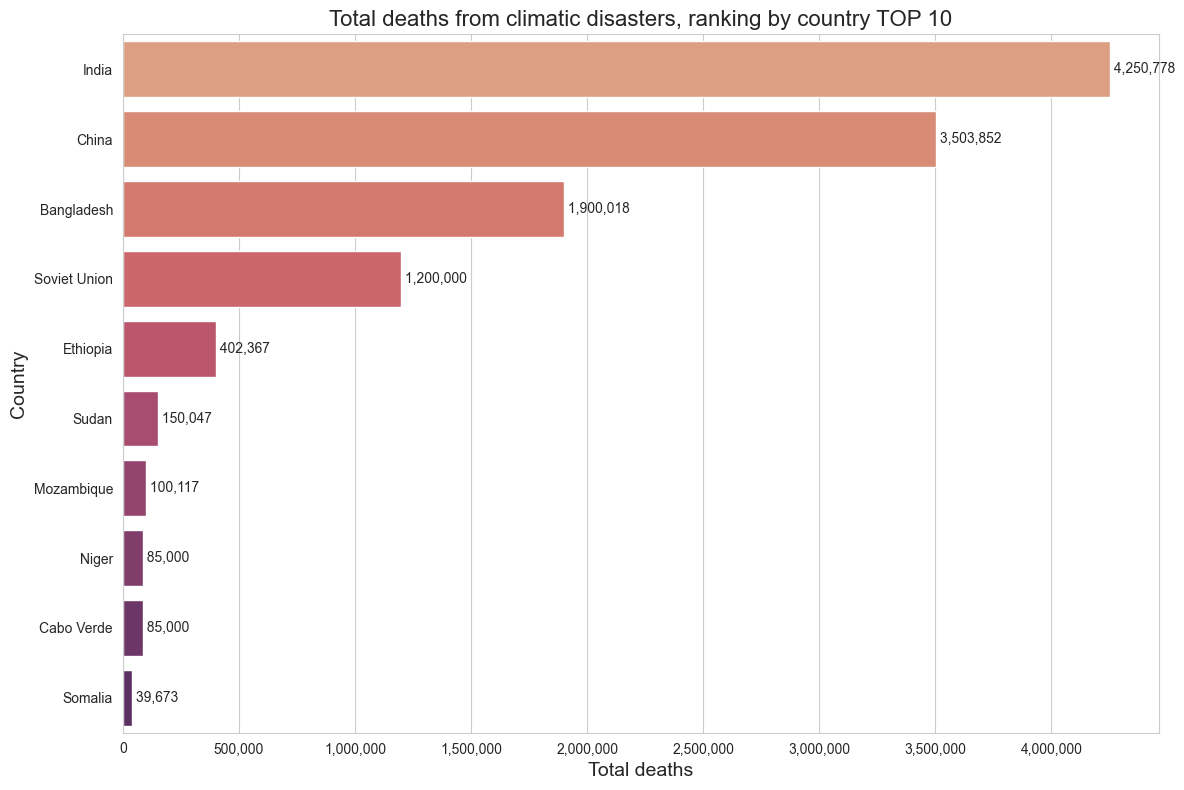

In [9]:
import pandas as pd
import japanize_matplotlib # 日本語表示のため
import matplotlib.pyplot as plt
import seaborn as sns

# データの読み込み
df = pd.read_csv('emdat.csv')

# --- 1. データのフィルタリングと集計 ---

# Disaster Subgroupが 'Climatological' の行のみを抽出
climatological_df = df[df['Disaster Subgroup'] == 'Climatological'].copy()

# 必要な列を抽出: 'Country' と 'Total Deaths'
df_clean = climatological_df[['Country', 'Total Deaths']].dropna()

# 'Total Deaths'列を数値型に変換し、NaNを削除
df_clean['Total Deaths'] = pd.to_numeric(df_clean['Total Deaths'], errors='coerce')
df_clean = df_clean.dropna(subset=['Total Deaths'])

# 'Country'ごとに 'Total Deaths' の合計を計算し、死者数の多い順にソートしてTOP 10を抽出
death_toll_by_country_top10 = df_clean.groupby('Country')['Total Deaths'].sum().sort_values(ascending=False).head(10)

# --- 2. 棒グラフの作成 ---

# グラフのスタイル設定
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8)) # グラフのサイズを設定

# 棒グラフの描画
ax = sns.barplot(
    x=death_toll_by_country_top10.values, # 死者数（Values）
    y=death_toll_by_country_top10.index,  # 国名（Index）
    palette="flare" # 色のパレット
)

# グラフのタイトルとラベル
plt.title('Total deaths from climatic disasters, ranking by country TOP 10', fontsize=16)
plt.xlabel('Total deaths', fontsize=14)
plt.ylabel('Country', fontsize=14)

# x軸の目盛りを分かりやすくするために、カンマ区切りでフォーマット
ax.ticklabel_format(style='plain', axis='x')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


# 棒の上に死者数を直接表示 (データラベルの追加)
for i, (value, name) in enumerate(zip(death_toll_by_country_top10.values, death_toll_by_country_top10.index)):
    ax.text(value, i, f' {value:,.0f}', va='center', ha='left', fontsize=10)


# グラフのレイアウト調整と表示
plt.tight_layout()
plt.show()

# まとめ

今回は、最初にヒートマップを作り死者数の多い地域と災害の種類について調べていきました。基本的には、死者数の多い国では多く災害が発生していました。しかしclimatlogicalの被害数は圧倒的にアメリカの方が多く発生したいましたがインドをはじめとするほかの地域の方が死者数が多い結果になりました。自分は、人口密度の差やインフラ整備などの差がこのような結果を出してしまうのかなと考えました。